In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Define constants for model
MAX_LENGTH = 500
OOD_MAX_LENGTH = 1500
VALID_CHARACTERS = ["s", "a", "b", "e", "p"]
VOCAB_SIZE = len(VALID_CHARACTERS)
EMBEDDING_DIM = 6
NUM_HEADS = 2
NUM_LAYERS = 1
HIDDEN_DIM = 2
BATCH_SIZE = 512
EPOCHS = 15

# Mapping characters to indices
char_to_index = {ch: idx for idx, ch in enumerate(VALID_CHARACTERS)}


# Custom dataset class
class StringDataset(Dataset):
    def __init__(self, file_path):
        self.data = []
        self.labels = []
        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split(" ")
                self.data.append(parts[0])
                self.labels.append(int(parts[1]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        string = self.data[idx]
        label = self.labels[idx]
        encoded = self.encode_string(string)
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(
            label, dtype=torch.float32
        )

    def encode_string(self, string):
        return [char_to_index[char] for char in string]


# Transformer model
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = nn.Parameter(torch.zeros(1, OOD_MAX_LENGTH, embedding_dim))
        encoder_layers = nn.TransformerEncoderLayer(
            embedding_dim, num_heads, hidden_dim
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(OOD_MAX_LENGTH * embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x) + self.pos_encoder
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.sigmoid(x)


# Initialize model, loss function, and optimizer
model = TransformerClassifier(
    VOCAB_SIZE, EMBEDDING_DIM, NUM_HEADS, HIDDEN_DIM, NUM_LAYERS
)
model.load_state_dict(
    torch.load(
        "short500_1500total_transformer_model.pth", map_location=torch.device("cpu")
    )
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu" and torch.backends.mps.is_available():
    device = torch.device("mps")
model.to(device)


test_dataset = StringDataset("test_dataset.txt")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load model from short500_1500total_transformer_model.pth

# Print accuracy of the model
model.eval()
# correct = 0
# total = 0
# for inputs, labels in tqdm(test_dataloader):
#     outputs = model(inputs.to(device))
#     predicted = torch.round(outputs)
#     total += labels.size(0)
#     correct += (predicted.squeeze().to(device) == labels.to(device)).sum().item()
# print(f"Accuracy: {correct/total}")

TransformerClassifier(
  (embedding): Embedding(5, 6)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=2, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2, out_features=6, bias=True)
        (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=9000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total number of parameters: 18255
pos_encoder: 9000
embedding.weight: 30
transformer_encoder.layers.0.self_attn.in_proj_weight: 108
transformer_encoder.layers.0.self_attn.in_proj_bias: 18
transformer_encoder.layers.0.self_attn.out_proj.weight: 36
transformer_encoder.layers.0.self_attn.out_proj.bias: 6
transformer_encoder.layers.0.linear1.weight: 12
transformer_encoder.layers.0.linear1.bias: 2
transformer_encoder.layers.0.linear2.weight: 12
transformer_encoder.layers.0.linear2.bias: 6
transformer_encoder.layers.0.norm1.weight: 6
transformer_encoder.layers.0.norm1.bias: 6
transformer_encoder.layers.0.norm2.weight: 6
transformer_encoder.layers.0.norm2.bias: 6
fc.weight: 9000
fc.bias: 1
tensor([[ 0.0353, -0.2371, -0.1736,  ..., -0.0073, -0.0048,  0.0022],
        [ 0.0336, -0.2384, -0.2366,  ..., -0.0018, -0.0131, -0.0098],
        [-0.0736,  0.3622,  0.3503,  ..., -0.0177, -0.0156, -0.0123],
        [-0.0190,  0.2431,  0.2962,  ...,  0.0068,  0.0017, -0.0074],
        [-0.0367,  0.1009,  

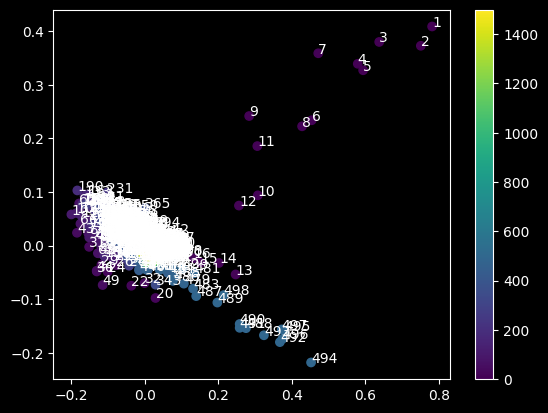

In [12]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Print the number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Print breakdown of parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

# Print weights of pos_encoder
print(model.pos_encoder.squeeze().T)

# We have 1,500 column vectors. Do PCA to reduce to 2 dimensions and graph as points with a gradient color based on the index of the column vector
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pos_encoder = model.pos_encoder.squeeze().cpu().detach().numpy()
pos_encoder_pca = pca.fit_transform(pos_encoder)
print(pos_encoder_pca)
plt.scatter(
    pos_encoder_pca[:, 0], pos_encoder_pca[:, 1], c=np.arange(1500), cmap="viridis"
)
plt.colorbar()
# Label points with their index
for i, txt in enumerate(np.arange(1500)):
    plt.annotate(txt, (pos_encoder_pca[i, 0], pos_encoder_pca[i, 1]))
plt.show()

tensor([[0, 2, 2,  ..., 4, 4, 4]])
tensor([[0.0018]], device='mps:0', grad_fn=<SigmoidBackward0>)
torch.Size([1, 1500, 6])
torch.Size([1500, 1, 1])


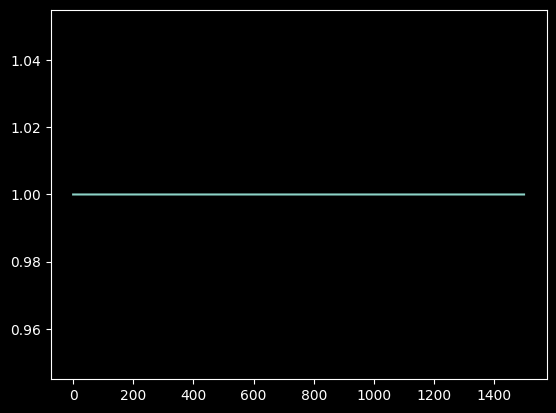

In [21]:
import random
import matplotlib.pyplot as plt

# Pick a random training example
inputs, labels = random.choice(test_dataset)
inputs = inputs.unsqueeze(0)
print(inputs)

# Forward pass through the model
outputs = model(inputs.to(device))
print(outputs)

# Set the model to evaluation mode
model.eval()

# Access the first layer of the transformer encoder
first_layer = model.transformer_encoder.layers[0]

# Get the embeddings and positional encodings
embeddings = model.embedding(inputs.to(device))

# Assuming pos_encoder is an attribute of the model that contains positional encodings
# If it's a method to generate positional encodings, call it with embeddings shape
positional_encodings = model.pos_encoder[: embeddings.size(1), :].to(device)
src = embeddings + positional_encodings

# Forward pass through the self-attention mechanism
self_attn_output, self_attn_weights = first_layer.self_attn(src, src, src)
print(self_attn_output.shape)
print(self_attn_weights.shape)

# Plot the self-attention weights
weights = self_attn_weights.squeeze().cpu().detach().numpy()
# Graph weights where x axis is index of the column vector and y axis is the weight
plt.plot(weights)
plt.show()

(1, 9000)
[[ 0.00687571 -0.01256908]
 [ 0.8048716   0.0726061 ]
 [ 0.6224634   0.07332794]
 ...
 [ 0.01715251  0.01463863]
 [-0.00609889 -0.00968721]
 [-0.02025962  0.05615013]]


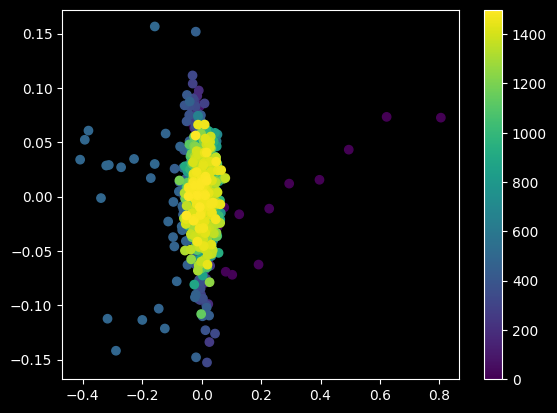

In [26]:
# Do PCA on the fc layer weights
fc_weights = model.fc.weight.cpu().detach().numpy()
print(fc_weights.shape)
fc_weights = fc_weights.reshape(1500, 6)
pca = PCA(n_components=2)
fc_weights_pca = pca.fit_transform(fc_weights)
print(fc_weights_pca)
plt.scatter(
    fc_weights_pca[:, 0], fc_weights_pca[:, 1], c=np.arange(1500), cmap="viridis"
)
plt.colorbar()
# Label points with their index
# for i, txt in enumerate(np.arange(1500)):
#     plt.annotate(txt, (fc_weights_pca[i,0], fc_weights_pca[i,1]))

In [35]:
import torch

# Assuming model, first_layer, and VOCAB_SIZE are already defined
input_str = "sabe" + "p" * (1500 - 4)
input_tensor = torch.tensor(
    [[ord(c) % VOCAB_SIZE for c in input_str]], dtype=torch.long
).to(device)

# Get attention weights. Run through embeddings and positional encodings
embeddings = model.embedding(input_tensor)
positional_encodings = model.pos_encoder[: embeddings.size(1), :].to(device)
print("Embeddings shape:", embeddings.shape)
print("Positional encodings shape:", positional_encodings.shape)

src = embeddings + positional_encodings

# Debug: check src before attention
print("Source (src) shape:", src.shape)
print("Source (src) values:", src)

# Manually get the Q, K, V matrices
Q = first_layer.self_attn.in_proj_q(src)

Embeddings shape: torch.Size([1, 1500, 6])
Positional encodings shape: torch.Size([1, 1500, 6])
Source (src) shape: torch.Size([1, 1500, 6])
Source (src) values: tensor([[[-0.0709,  1.1455, -0.4318, -1.1220,  0.7866,  0.4607],
         [-0.1515,  0.3816,  1.2954, -0.8499, -0.6505,  0.4265],
         [-0.6817, -0.4691,  0.9032,  0.5726,  0.1894, -0.6389],
         ...,
         [ 0.0784,  0.6181,  0.9156, -1.0862, -0.7493,  1.1634],
         [ 0.0809,  0.6069,  0.9177, -1.0913, -0.7476,  1.1595],
         [ 0.0878,  0.6102,  0.9210, -1.1004, -0.7437,  1.1564]]],
       device='mps:0', grad_fn=<AddBackward0>)


AttributeError: 'MultiheadAttention' object has no attribute 'in_proj_q'